# Aufgabe für die Projektgruppe 1

Bearbeiten Sie die folgende Aufgabe:

Ihr Auftraggeber ist eine Familie, welche eine Beratung von Ihnen benötigt. Sie besitzt ein kleines altes Windrad, welches nur für den Eigenverbrauch genutzt wird sowie eine PV Anlage. Die Familie möchte von Ihnen wissen, ob Sie Kosten durch die Investition in verschiedene Komponenten ihres Energiesystems einsparen kann. 

Nehmen Sie dabei die folgenden Angaben an:
* Nennleistung der Windernergieanlage: 5 kW (Keine EEG- Vergütung)
* Nennleistung der PV-Anlage 9 kWp (70% Kappungsgrenze berücksichtigen)
* Die Anschlussleistung an das elektrische Netz beträgt 15 kW
* Die Heizleistung des Erdgaskessel liegt bei 20 kW, der Wirkungsgrad ist 99%
* Erdgaspreis: 7 cent/kWh
* Strompreis: 30 cent/kWh
* EEG-Vergütung PV Anlage: 12,30 cent/kWh

Prüfen und kombinieren Sie mindestens drei der unten aufgeführten Optionen und bewerten Sie diese nach ihrer wirtschaftlicher Vorteilhaftigkeit. Unter den gewählten Optionen sollte sich mindestens eine der beiden Optionen BHKW oder Wärmepumpe befinden:
- Implementierung eines Heizstabes mit annuitätische Kosten von 50€ (Elektrische Leistung 5 kW, Wirkungsgrad 98%) 
- Installation eines BHKWs mit annuitätische Kosten von 1.200€ (Elektrische Leistung 1kW, elektrischer Wirkungsgrad 16%, Thermischer Wirkungsgrad 80%, nehmen Sie eine feste Stromkennzahl von 0,2 an, ein Beispiel für die Implementierung eines BHKWs in PyPSA finden Sie hier: https://pypsa.org/examples/chp-fixed-heat-power-ratio.html. Eine KWK-Vergütung müssen Sie nicht implementieren, da hier die pauschalierte Zuschlagzahlung gewählt wird.)
- Beschaffung einer elektrischen Batterie mit annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste) 
- Erweiterung des Heizungssystems um einen thermischen Speicher mit annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)
- Implementierung einer selbst gewählten Wärmepumpe. Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

1) Formulieren Sie die Optimierungsaufgabe
2) Skizzieren Sie das heutige System und bestimmen Sie die Kosten.
3) Skizzieren Sie mögliche Erweiterungen und bestimmen Sie die Kosten.
4) Interpretieren Sie die ihre Ergebnisse und ziehen Sie Schlussfolgerungen.
5) Bestimmen Sie die Grenzen Ihrer Modellierung und begründen Sie, ob die Ergebnisse trotz der Beschränkungen valide sind.

Der Import der Lastzeitreihen und der Einspeisezeitreihen ist unten schon vorbereitet. Diese repräsentieren das Jahr 2018 in stündlicher Auflösung. Nutzen Sie das in der Übung besprochene JupyterNotebook und schauen Sie sich die Funktionen und den Code dort an, um Ihr Energiesystem aufzubauen, es zu simulieren und auszuwerten.  

# Import <a class="anchor" id="chapter1"></a>

## Import der benötigten Python Module <a class="anchor" id="section_1_1"></a>

In [1]:
import pypsa
import pandas as pd
import math
import numpy as np
from IPython.display import Image

## Import der Daten <a class="anchor" id="section_1_2"></a>

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie bilden das Jahr 2019 ab und werden mithilfe des Python Moduls pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Separator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt.

In [2]:
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)
wind_infeed = pd.read_csv('./data/wind_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)

In [3]:
electrical_load = pd.read_csv('./data/SumProfiles_3600s.Electricity.csv', sep = ';', index_col='time', parse_dates=True)
thermal_load = pd.read_csv('./data/SumProfiles_3600s.Gas.csv', sep = ';', index_col='time', parse_dates=True)


Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Einspeisung der Wind und PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mit der Leistung der Last in den jeweiligen Variablen angelegt.

In [4]:
#Die gemessene PV-Einspeiseganglinie ist von einer Anlage mit einer Leistung von 9 kWp, die der Windenergieanlage mit 5 kW.
pv_infeed['p_max_pu'] = pv_infeed.electricity/9 
wind_infeed['p_max_pu'] = wind_infeed.electricity/5 


Um einen kurzen Einblick in die Daten zu erhalten, schauen wir uns alle vier Tabellen an:

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

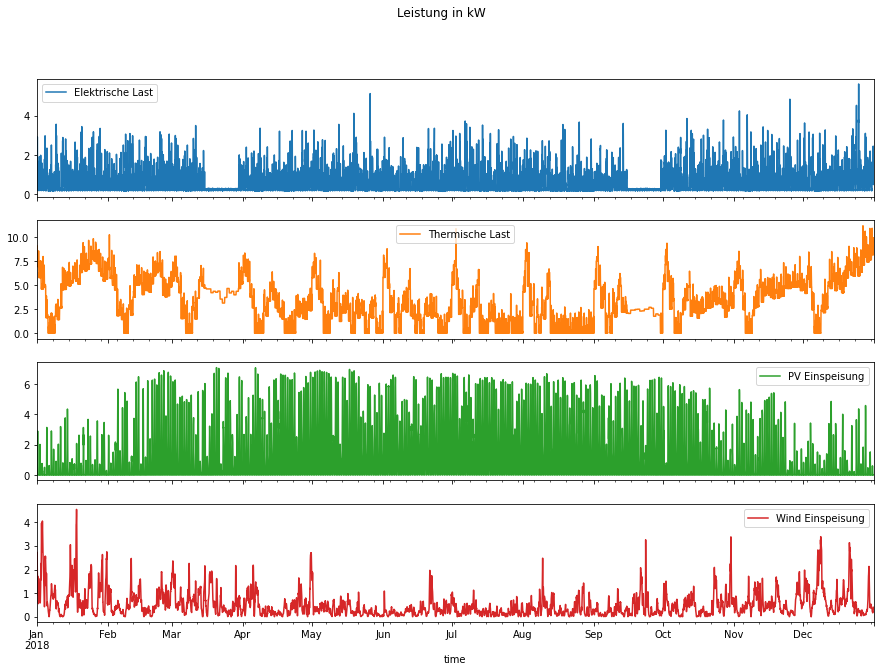

In [5]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

## Variable für Länge der Betrachtung in Jahre
(wichtig für die Gesamtkosten der Annuitäten und anderen jährlichen Kosten)

# Definition der Objekte

In [6]:
# PV-Anlage
pv = {"electrical_power": 9.0}       #elektrische Leistung

# Windrad
wind_wheel = {"electrical_power": 5} # elektrische Leistung

# Erdgaskessel
heating_boiler = {"thermal_power": 20.0, # Thermische Leistung
                   "efficiency":0.99,# Effizienz als normierte Kennzahl
                   "gas_costs": 7.0} #Kosten in cent/kWh

# Wärmepumpe
heat_pump = {"thermal_power": 2,    # Thermische Leistung
            "COP": 2.8,
            "electrical_costs": 30, #cent/kWh
            "Investition": 15000,   # in Euro
            "Annuitätsfaktor": 0.117} 

#Warmwasserspeicher
hot_water_storage =  {"thermal_power": 12.0, # Thermische Leistung
                   "thermal_capacity":7.0, #Kapazität in kWh
                   "standing_loss": 0.00,  #Selbstentladungsverluste in Energie des Speicherinhalts, der sich nach einer Stunde selbst entladen hat.
                    "annuity_cost": 100 } #Jährliche Kosten in Euro

# Batteriespeicher
battery_storage = {"electrical_power": 2.4, # elektrische Leistung
                      "efficiency": 0.85,   #Effizienz
                      "standing_loss": 0.00, # Selbstentladungsverluste
                      "electrical_capacity": 8.00, # elektrische Kapazität
                      "annuity_cost": 900}   #Jährliche Kosten in Euro

# Netzanschluss

In [7]:
# Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 15,    # elektrische Leistung
                "electricity_price": 30.0} #Preise in cent/kWh

#Leistungsabgabe in das Netz
grid_export = {"electrical_power" : 0.7 * pv["electrical_power"], # 70% Kappungsgrenze bei kleinen PV-Anlagen
                "electricity_revenue": 12.3} #EEG-Erlöse in cent/kWh

# Definition des Netzes

In [8]:
#Netzwerk definieren
network = pypsa.Network()
network.set_snapshots(pv_infeed.index)
network.set_snapshots(wind_infeed.index)
network.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) # der Parameter 1 repräsentiert die stündliche Abfrage

# Knoten definieren

In [9]:
#Stromknoten definieren
network.add("Bus", 
            name = "electricity")       

#Wärmeknoten definieren
network.add("Bus", 
            name = "thermal")           

# Lasten definieren

In [10]:
# Elektrische Last
network.add("Load", 
            name ="electricity_load",           
            bus = "electricity",                  #Verknüpfung zum Stromknoten
            p_set = electrical_load.sum_kwh)      #Zuweisung der elektrischen Lasten des Haushalts

# Thermische last
network.add("Load", 
            name ="thermal_load", 
            bus = "thermal",                      #Verknüpfung zum Wärmeknoten
            p_set = thermal_load.sum_kwh)         #Zuweiseung der thermischen Lasten des Haushalts

# Generatoren definieren

In [11]:
# PV
network.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"],          #Die Nennleistung wird vom Objekt oben übernommen
            p_max_pu = pv_infeed.p_max_pu,           #Übergabe der PV-Erzeugungsleistung
            marginal_cost = 0)                       #Grenzkosten, die entstehen, wenn eine zusätzliche Einheit produziert wird
                                                     #Laufende/Zusätzliche Kosten

# Windrad
network.add("Generator",
            name = "wind", 
            bus = "electricity", 
            p_nom = wind_wheel["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

# Erdgaskessel
network.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"],
            efficiency=heating_boiler["efficiency"],    #Der Wert der Effizienz/Wirkungsgrad wird vom Objekt oben übernommen
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])    #Grenzkosten: In diesem Fall zusätzliche
                                                                                         #Kosten des Gases abhängig vom WG



# Netzanschluss definieren

In [12]:
#Netzbezug
network.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

# Simulation der Basiskonfiguration

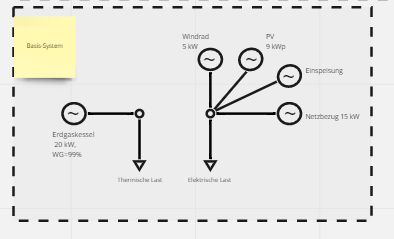

In [13]:
Image(filename='konfig_basis.PNG')     #Darstellung des geladenen Bildes

In [14]:
# Simulation für den kompletten Zeitraum:
network.lopf(solver_name = "glpk", pyomo = False)#Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und 
                                                 #Rechenzeit zu sparen. Optimierungsfkn. von Erzeugung, Speicher, Übertragung

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.43s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.94e+04


('ok', 'optimal')

# Auswertung

In [15]:
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):

    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum() #Berechnung des Netzbezugs über
        #oben festgelegte Abfrageschritte "1"
    grid_export = (network.generators_t.p['grid_export'] * network.snapshot_weightings).sum()
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum()- grid_export
    #Berechnung des Selbstverbrauchs aus PV
    self_consumed_wind = (network.generators_t.p['wind'] * network.snapshot_weightings).sum()
    #Berechnung des Selsbtverbrauchs von Windrad
    self_consumption_ratio = (self_consumed_pv + self_consumed_wind) /(grid_import + self_consumed_pv + self_consumed_wind)
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import'] 
    #Berechnung Stromkosten aus Strombezug und oben zugewiesener Preis
    electricty_revenues = grid_export * network.generators.marginal_cost['grid_export'] #Erlöse durch Netzeinspeisung
    gas_costs = (network.generators_t.p['boiler']*network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
   #annuity_cost = ((hot_water_storage['annuity_cost'] + heat_pump['Investition']/AnzJ + battery_storage["annuity_cost"])*100)
    
    curtailment = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()
    #Verlust/Einschränkung durch die 70%-Grenze
    results_base = {"Eigenverbrauchsanteil": self_consumption_ratio,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricty_revenues,
              "Energiekosten": electricity_cost + gas_costs, 
               #+ annuity_cost,
              "Nicht nutzbare Energie": curtailment}
    results_energy_base = {'Abregelung': curtailment,
                      'Netzeinspeisung': grid_export,
                      'Eigenverbrauch': self_consumed_pv + self_consumed_wind,
                      'Netzbezug': -grid_import}
                      
    return results_base, results_energy_base

In [16]:
# Ausführung der Auswertungsfunktion
results_base, results_energy_base = cost_share_evaluation(network)
#cashflow und weitere Ergebnisse berechnen:
cashflow_base = results_base["Stromerlöse"]-results_base["Energiekosten"] #in cent

print("Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt "
      + str(round(results_base["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_base["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_base["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_base["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_base["Nicht nutzbare Energie"]/100,4))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtenergiekosten betragen "+ str(round(results_base["Energiekosten"]/100,2)) # Umwandlung in €
      +"€.\n"
      + "Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_base)/100,2))
      + "€.\n")


Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt 68.98%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1891.83€ und EEG-Erlöse von 1469.02, wobei 0.0944kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtenergiekosten betragen 2363.42€.
Der Cashflow für das Jahr 2018 beträgt somit -894.4€.



# Visualisierung der Ergebnisse

<AxesSubplot:xlabel='time'>

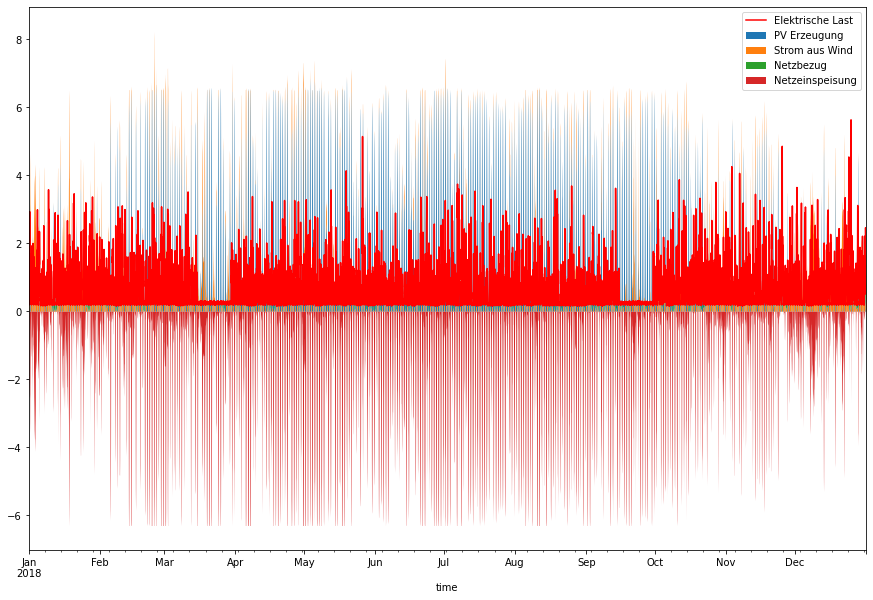

In [17]:
#Darstellung der Lasten und berechneten Werte in grafischer Form:
load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_with_modification = pd.concat([network.generators_t.p['pv'], network.generators_t.p['wind'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export']], axis = 1)
df_figure_with_modification.columns = ['PV Erzeugung', 'Strom aus Wind', 'Netzbezug', 'Netzeinspeisung']
df_figure_with_modification.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax = ax)

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh'}>

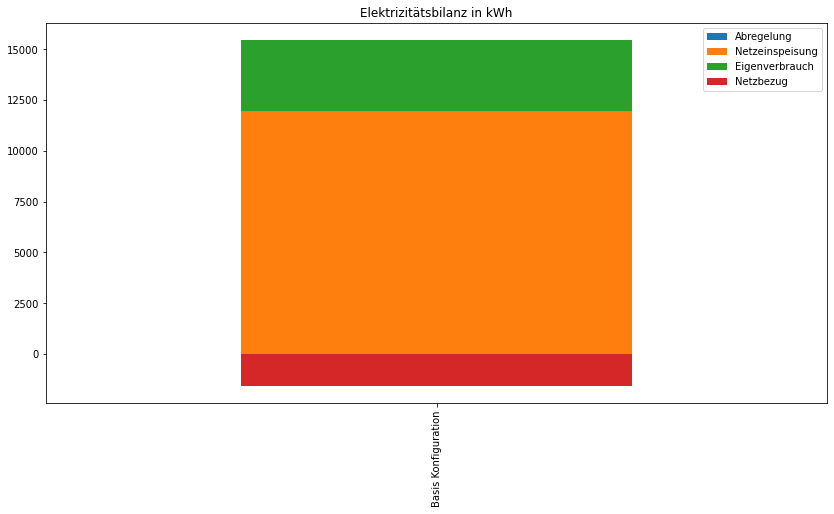

In [18]:
#Darstellung der Elektrizitätsbilanz als Säulendiagramm
energy_figure = pd.DataFrame([results_energy_base], index = ['Basis Konfiguration'])
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')

# Modifikation: Wärmepumpe

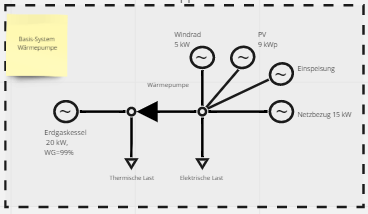

In [19]:
Image(filename='konfig_hp.PNG')

In [20]:
#Basisnetzwerk definieren
network_mod_hp = pypsa.Network()
network_mod_hp.set_snapshots(pv_infeed.index)
network_mod_hp.set_snapshots(wind_infeed.index)
network_mod_hp.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) # Abfrage stündlich
#Stromknoten definieren
network_mod_hp.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_mod_hp.add("Bus", 
            name = "thermal")
# Elektrische Last
network_mod_hp.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_mod_hp.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
# PV
network_mod_hp.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
# Windrad
network_mod_hp.add("Generator",
            name = "wind", 
            bus = "electricity", 
            p_nom = wind_wheel["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
# Erdgaskessel
network_mod_hp.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"],
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])
#Netzbezug
network_mod_hp.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_mod_hp.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.



In [21]:
# Wärmepumpe
network_mod_hp.add("Link",
            name = "heat_pump", 
            bus0 = "electricity",
            bus1 = "thermal",
            p_nom = heat_pump["thermal_power"],     # Nennleistung 
            efficiency = heat_pump["COP"]
           )

In [22]:
# Simulation für den kompletten Zeitraum:
network_mod_hp.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.        

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.26s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 6.06e+04


('ok', 'optimal')

In [23]:
# Ausführung der Auswertungsfunktion
results_with_hp, results_energy_with_hp = cost_share_evaluation(network_mod_hp)
#Zusätzliche Kosten
zusätzliche_Kosten_wp = heat_pump["Investition"]*heat_pump["Annuitätsfaktor"]*100 #in cent
#Anzeige ua. Cashflow, Eigenverbrauch, Strom-, Gaskosten, EEG_Erlöse, Verluste durch Kappung als Anzeigetest
cashflow_hp = results_with_hp["Stromerlöse"]-results_with_hp["Energiekosten"]- zusätzliche_Kosten_wp #in cent


print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
+str(round(results_with_hp["Eigenverbrauchsanteil"]*100,2))
+"%.\n Dabei entstehen Stromkosten von "
+str(round(results_with_hp["Stromkosten"]/100,2))
+"€, Gaskosten von "
+str(round(results_with_hp["Gaskosten"]/100,2))
+"€ und EEG-Erlöse von "
+str(round(results_with_hp["Stromerlöse"]/100,2))
+", wobei " 
+str(round(results_with_hp["Nicht nutzbare Energie"]/100,4))
+"kWh PV-Strom abgeregelt werden müssen.\n"
+" Die Gesamtenergiekosten betragen "
+str(round((results_with_hp["Energiekosten"] + zusätzliche_Kosten_wp)/100,2))
+"€.\n"
+"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
+str(round((results_with_hp["Eigenverbrauchsanteil"] - results_base["Eigenverbrauchsanteil"])*100,2))
+" Prozentpunkte und eine Verringerung der Kosten um "
+str(round((cashflow_hp-cashflow_base)/100,2))
+"€. "
+ "Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_hp)/100,2))
+ "€.\n")


Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 82.13%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1153.87€ und EEG-Erlöse von 1019.73, wobei 0.0324kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtenergiekosten betragen 3380.46€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 13.15 Prozentpunkte und eine Verringerung der Kosten um -1466.33€. Der Cashflow für das Jahr 2018 beträgt somit -2360.72€.



# Visualisierung des Vergleichs

<AxesSubplot:xlabel='time'>

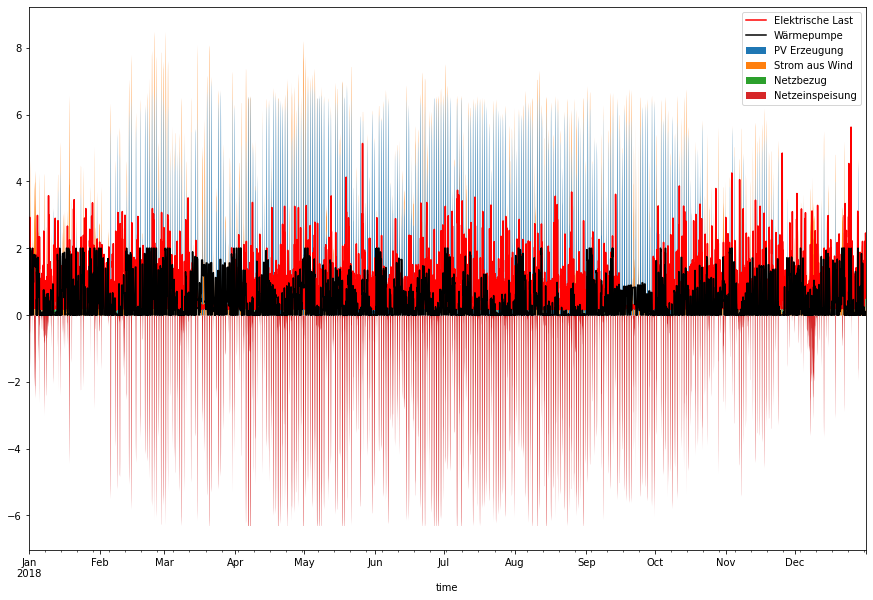

In [24]:
total_load = pd.concat([network_mod_hp.loads_t.p_set['electricity_load'], network_mod_hp.links_t.p0['heat_pump']], axis = 1)
total_load.columns = ['Elektrische Last', 'Wärmepumpe']
ax = total_load.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_with_hp = pd.concat([network_mod_hp.generators_t.p['pv'], network_mod_hp.generators_t.p['wind'], network_mod_hp.generators_t.p['grid_import'], -network_mod_hp.generators_t.p['grid_export']], axis = 1)
df_figure_with_hp.columns = ['PV Erzeugung', 'Strom aus Wind', 'Netzbezug', 'Netzeinspeisung']
df_figure_with_hp.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax = ax)

In [25]:
energy_figure_hp = pd.DataFrame([results_energy_base, results_energy_with_hp], index = ['Basis', 'Mit WP'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh'}>

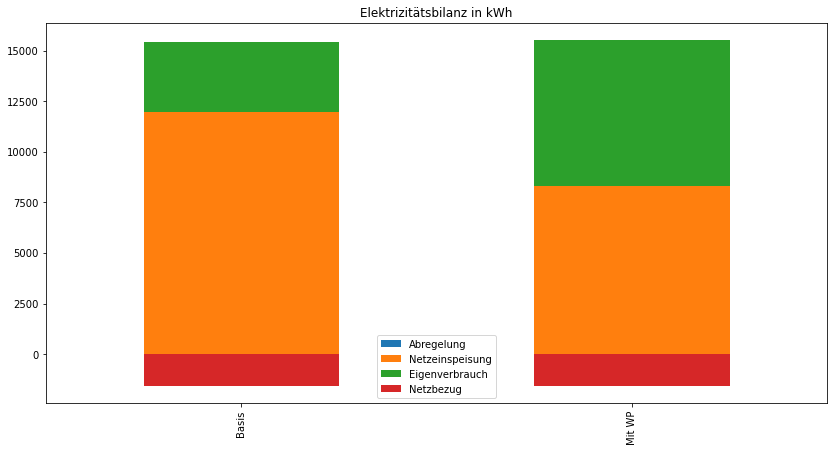

In [26]:
energy_figure_hp.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')

# Modifikation: Warmwasserspeicher (hot water tank)

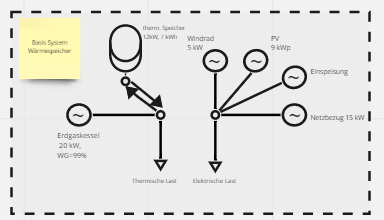

In [27]:
Image(filename='konfig_hwt.PNG')

In [28]:
#Basisnetzwerk definieren
network_mod_hwt = pypsa.Network()
network_mod_hwt.set_snapshots(pv_infeed.index)
network_mod_hwt.set_snapshots(wind_infeed.index)
network_mod_hwt.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) # Abfrage stündlich
#Stromknoten definieren
network_mod_hwt.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_mod_hwt.add("Bus", 
            name = "thermal")
# Elektrische Last
network_mod_hwt.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_mod_hwt.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
# PV
network_mod_hwt.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
# Windrad
network_mod_hwt.add("Generator",
            name = "wind", 
            bus = "electricity", 
            p_nom = wind_wheel["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
# Erdgaskessel
network_mod_hwt.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"],
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])
#Netzbezug
network_mod_hwt.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_mod_hwt.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.



In [29]:
# Warmwasserspeicher
# Hilfknoten
network_mod_hwt.add("Bus",
           name = "thermal_storage")
#Einspeicherleistung vom Knoten "thermal" zum Knoten "thermal_storage"
network_mod_hwt.add("Link",
           name = "hot_water_storage_charge",
           bus0 = "thermal",
           bus1 = "thermal_storage",
           p_nom = hot_water_storage["thermal_power"])

#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_mod_hwt.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "thermal_storage", 
            bus1 = "thermal", 
            p_nom = hot_water_storage["thermal_power"])

#Speicher
network_mod_hwt.add("Store", 
            name = "hot_water_storage", 
            bus = "thermal_storage", 
            e_nom = hot_water_storage["thermal_capacity"],
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            standing_loss = hot_water_storage["standing_loss"] #Selbstentladungsverluste
            )

In [30]:
# Simulation für den kompletten Zeitraum:
network_mod_hwt.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.        

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.58s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.94e+04


('ok', 'optimal')

In [31]:
# Ausführung der Auswertungsfunktion
results_with_hwt, results_energy_with_hwt = cost_share_evaluation(network_mod_hwt)
#Zusätzliche Kosten
zusätzliche_Kosten_hwt = hot_water_storage["annuity_cost"]*100 #jahrliche Kosten in Cent
#Cashflow berechnen
cashflow_hwt = results_with_hwt["Stromerlöse"]-results_with_hwt["Energiekosten"]- zusätzliche_Kosten_hwt #in cent


print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
+ str(round(results_with_hwt["Eigenverbrauchsanteil"]*100,2))
+"%.\n Dabei entstehen Stromkosten von "
+str(round(results_with_hwt["Stromkosten"]/100,2))
+"€, Gaskosten von "
+str(round(results_with_hwt["Gaskosten"]/100,2))
+"€ und EEG-Erlöse von "
+str(round(results_with_hwt["Stromerlöse"]/100,2))
+", wobei " +str(round(results_with_hwt["Nicht nutzbare Energie"]/100,1))
+ "kWh PV-Strom abgeregelt werden müssen.\n"
+" Die Gesamtenergiekosten betragen "+ str(round((results_with_hwt["Energiekosten"]+zusätzliche_Kosten_hwt)/100,2))
+"€.\n"
+"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
+str(round((results_with_hwt["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
+" Prozentpunkte und eine Verringerung der Kosten um "
+str(round((cashflow_hwt-cashflow_base)/100,2))
+"€. "
+ "Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_hwt)/100,2))
+ "€.\n")

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 68.98%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1891.83€ und EEG-Erlöse von 1469.02, wobei 0.1kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtenergiekosten betragen 2463.42€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 0.0 Prozentpunkte und eine Verringerung der Kosten um -100.0€. Der Cashflow für das Jahr 2018 beträgt somit -994.4€.



# Visualisierung des Vergleichs

<AxesSubplot:xlabel='time'>

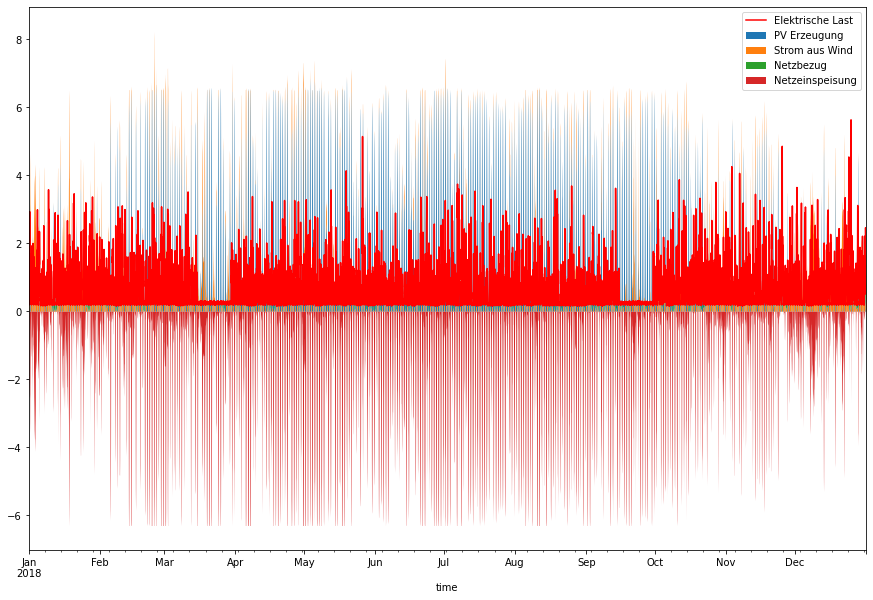

In [32]:
load_figure = network_mod_hwt.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_with_hwt = pd.concat([network_mod_hwt.generators_t.p['pv'], network_mod_hwt.generators_t.p['wind'], network_mod_hwt.generators_t.p['grid_import'], -network_mod_hwt.generators_t.p['grid_export']], axis = 1)
df_figure_with_hwt.columns = ['PV Erzeugung', 'Strom aus Wind', 'Netzbezug', 'Netzeinspeisung']
df_figure_with_hwt.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax = ax)

In [33]:
energy_figure_hwt = pd.DataFrame([results_energy_base, results_energy_with_hwt], index = ['Basis', 'Mit WW-Speicher'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh'}>

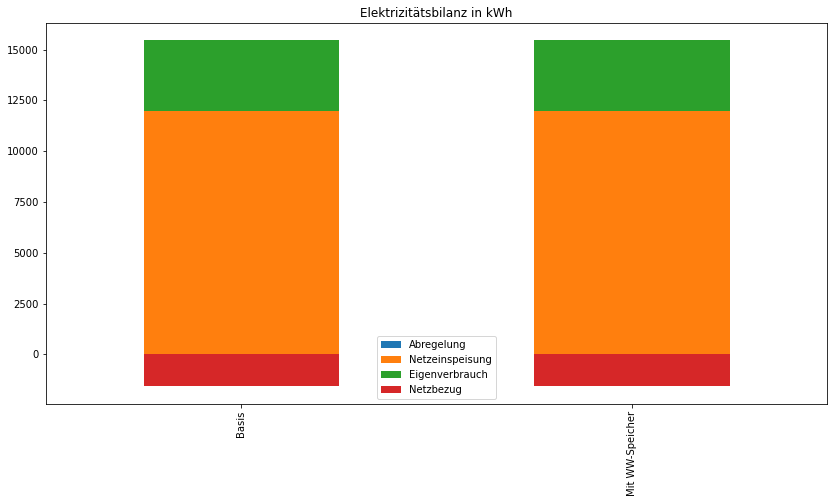

In [34]:
energy_figure_hwt.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')

# Modifikation: Batteriespeicher

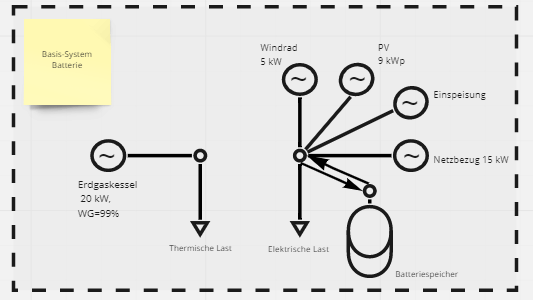

In [35]:
Image(filename='konfig_bat.PNG')

In [36]:
#Basisnetzwerk definieren
network_mod_bat = pypsa.Network()
network_mod_bat.set_snapshots(pv_infeed.index)
network_mod_bat.set_snapshots(wind_infeed.index)
network_mod_bat.snapshot_weightings = pd.Series(data = 1, index = network.snapshots) # Abfrage stünlich
#Stromknoten definieren
network_mod_bat.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_mod_bat.add("Bus", 
            name = "thermal")
# Elektrische Last
network_mod_bat.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_mod_bat.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
# PV
network_mod_bat.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
# Windrad
network_mod_bat.add("Generator",
            name = "wind", 
            bus = "electricity", 
            p_nom = wind_wheel["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
# Erdgaskessel
network_mod_bat.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"],
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])
#Netzbezug
network_mod_bat.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_mod_bat.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


In [37]:
# Batteriespeicher
# Hilfsknoten weil Datenaustausch in beide Richtungen möglich sein muss
network_mod_bat.add("Bus",
           name = "electricity_storage")
# Einspeicherleistung
network_mod_bat.add("Link",
           name = "electrical_storage_charge",
           bus0 = "electricity",
           bus1 = "electricity_storage",
           p_nom = battery_storage["electrical_power"],
           effeciency = battery_storage["efficiency"])
#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_mod_bat.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "electricity_storage", 
            bus1 = "electricity", 
            p_nom = battery_storage["electrical_power"],
            efficiency = battery_storage["efficiency"]
                    )
#Speicher
network_mod_bat.add("Store", 
            name = "electricity_storage", 
            bus = "electricity_storage", 
            e_nom = battery_storage["electrical_capacity"],
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            standing_loss = battery_storage["standing_loss"]
            )


In [38]:
# Simulation für den kompletten Zeitraum:
network_mod_bat.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.        

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.97s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 6.77e+04


('ok', 'optimal')

In [39]:
# Ausführung der Auswertungsfunktion
results_with_bat, results_energy_with_bat = cost_share_evaluation(network_mod_bat)
#Zusätzliche Kosten
zusätzliche_Kosten_bat = battery_storage["annuity_cost"]*100 # in cent
#Berechnung von ua. Cashflow, Gesamtkosten, Selbstverbrauch
cashflow_bat = results_with_bat["Stromerlöse"]-results_with_bat["Energiekosten"]- zusätzliche_Kosten_bat #in cent


print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
+ str(round(results_with_bat["Eigenverbrauchsanteil"]*100,2))
+"%.\n Dabei entstehen Stromkosten von "
+str(round(results_with_bat["Stromkosten"]/100,2))
+"€, Gaskosten von "
+str(round(results_with_bat["Gaskosten"]/100,2))
+"€ und EEG-Erlöse von "
+str(round(results_with_bat["Stromerlöse"]/100,2))
+", wobei " +str(round(results_with_bat["Nicht nutzbare Energie"]/100,1))
+ "kWh PV-Strom abgeregelt werden müssen.\n"
+" Die Gesamtkosten betragen "+ str(round((results_with_bat["Energiekosten"]+zusätzliche_Kosten_bat)/100,2)) 
+"€.\n"
+"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
+str(round((results_with_bat["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
+" Prozentpunkte und eine Verringerung der Kosten um "
+str(round((cashflow_bat - cashflow_base)/100,2))
+"€."
+" Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_bat)/100,2))
+"€.\n")


Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 95.21%.
 Dabei entstehen Stromkosten von 76.15€, Gaskosten von 1891.83€ und EEG-Erlöse von 1291.38, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 2867.98€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 26.23 Prozentpunkte und eine Verringerung der Kosten um -682.21€. Der Cashflow für das Jahr 2018 beträgt somit -1576.6€.



# Visualisierung des Vergleichs

<AxesSubplot:xlabel='time'>

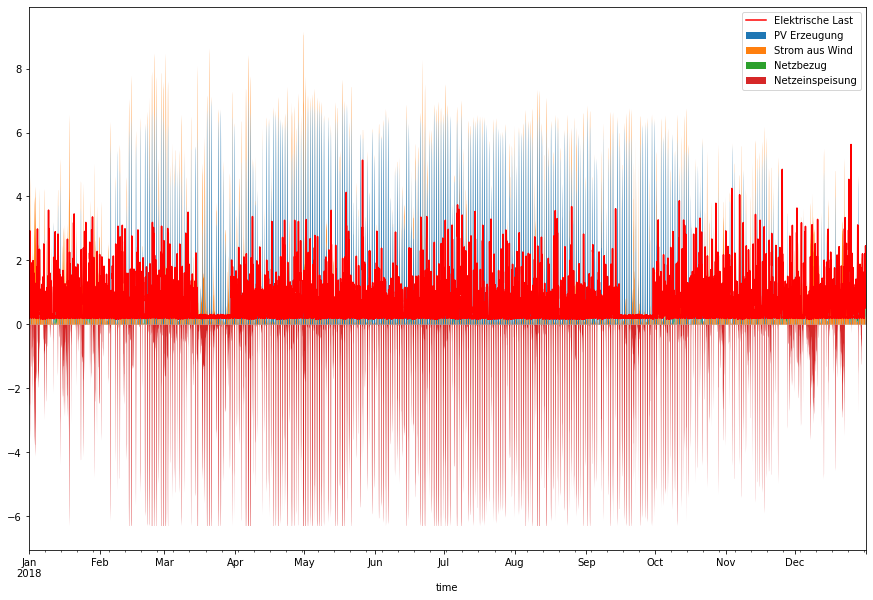

In [40]:
load_figure = network_mod_bat.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_with_bat = pd.concat([network_mod_bat.generators_t.p['pv'], network_mod_bat.generators_t.p['wind'], network_mod_bat.generators_t.p['grid_import'], -network_mod_bat.generators_t.p['grid_export']], axis = 1)
df_figure_with_bat.columns = ['PV Erzeugung', 'Strom aus Wind', 'Netzbezug', 'Netzeinspeisung']
df_figure_with_bat.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax = ax)

In [41]:
energy_figure_bat = pd.DataFrame([results_energy_base, results_energy_with_bat], index = ['Basis', 'Mit Batterie'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh'}>

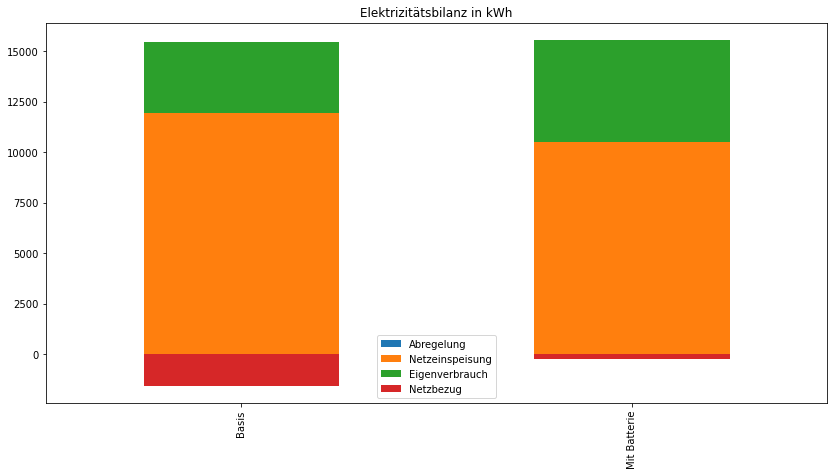

In [42]:
energy_figure_bat.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')

# Modifikation: Alle bisherigen kombiniert

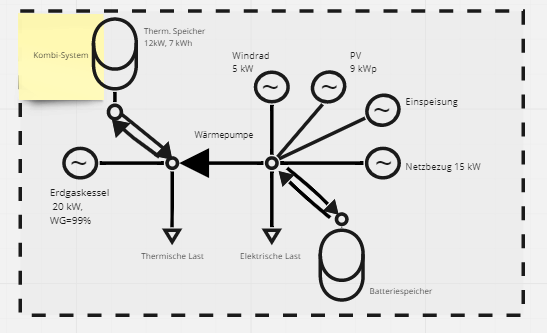

In [43]:
Image(filename='konfig_kombi.PNG')

In [44]:
#Basisnetzwerk definieren
network_mod_all = pypsa.Network()
network_mod_all.set_snapshots(pv_infeed.index)
network_mod_all.set_snapshots(wind_infeed.index)
network_mod_all.snapshot_weightings = pd.Series(data = 1, index = network.snapshots)   #Abfrage stündlich
#Stromknoten definieren
network_mod_all.add("Bus", 
            name = "electricity")
#Wärmeknoten definieren
network_mod_all.add("Bus", 
            name = "thermal")
# Elektrische Last
network_mod_all.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.sum_kwh)
# Thermische last
network_mod_all.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.sum_kwh)
# PV
network_mod_all.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)
# Windrad
network_mod_all.add("Generator",
            name = "wind", 
            bus = "electricity", 
            p_nom = wind_wheel["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)
# Erdgaskessel
network_mod_all.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"],
            efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])
#Netzbezug
network_mod_all.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])
#Netzeinspeisung
network_mod_all.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


In [45]:
# Wärmepumpe
network_mod_all.add("Link",
            name = "heat_pump", 
            bus0 = "electricity",
            bus1 = "thermal",
            p_nom = heat_pump["thermal_power"],     # Nominale Leistung 
            efficiency = heat_pump["COP"]
           )

# Warmwasserspeicher
# Hilfknoten
network_mod_all.add("Bus",
           name = "thermal_storage")
#Einspeicherleistung vom Knoten "thermal" zum Knoten "thermal_storage"
network_mod_all.add("Link",
           name = "hot_water_storage_charge",
           bus0 = "thermal",
           bus1 = "thermal_storage",
           p_nom = hot_water_storage["thermal_power"])
#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_mod_all.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "thermal_storage", 
            bus1 = "thermal", 
            p_nom = hot_water_storage["thermal_power"])
#Speicher
network_mod_all.add("Store", 
            name = "hot_water_storage", 
            bus = "thermal_storage", 
            e_nom = hot_water_storage["thermal_capacity"],
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            standing_loss = hot_water_storage["standing_loss"]
            )

# Batteriespeicher
# Hilfsknoten
network_mod_all.add("Bus",
           name = "electricity_storage")
# Einspeicherleistung
network_mod_all.add("Link",
           name = "electrical_storage_charge",
           bus0 = "electricity",
           bus1 = "electricity_storage",
           p_nom = battery_storage["electrical_power"],
           effeciency = battery_storage["efficiency"])
#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_mod_all.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "electricity_storage", 
            bus1 = "electricity", 
            p_nom = battery_storage["electrical_power"],
            efficiency = battery_storage["efficiency"])
#Speicher
network_mod_all.add("Store", 
            name = "electricity_storage", 
            bus = "electricity_storage", 
            e_nom = battery_storage["electrical_capacity"],
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            standing_loss = battery_storage["standing_loss"])


In [46]:
# Simulation für den kompletten Zeitraum:
network_mod_all.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.        

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 2.12s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.38e+04


('ok', 'optimal')

In [47]:
# Ausführung der Auswertungsfunktion
results_with_all, results_energy_with_all = cost_share_evaluation(network_mod_all) # Funktion übergeben
#Zusätzliche Kosten
zusätzliche_Kosten_all = zusätzliche_Kosten_wp + zusätzliche_Kosten_bat +zusätzliche_Kosten_hwt
#Berechnung von au. Cashflow, Gesamtkosten, Selbstverbrauch
cashflow_all = results_with_all["Stromerlöse"]-results_with_all["Energiekosten"]- zusätzliche_Kosten_all


print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
+ str(round(results_with_all["Eigenverbrauchsanteil"]*100,2))
+"%.\n Dabei entstehen Stromkosten von "
+str(round(results_with_all["Stromkosten"]/100,2))
+"€, Gaskosten von "
+str(round(results_with_all["Gaskosten"]/100,2))
+"€ und EEG-Erlöse von "
+str(round(results_with_all["Stromerlöse"]/100,2))
+", wobei " +str(round(results_with_all["Nicht nutzbare Energie"]/100,1))
+ "kWh PV-Strom abgeregelt werden müssen.\n"
+" Die Gesamtkosten betragen "+ str(round((results_with_all["Energiekosten"]+zusätzliche_Kosten_all)/100,2)) 
+"€.\n"
+"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
+str(round((results_with_all["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
+" Prozentpunkte und eine Verringerung der Kosten um "
+str(round((cashflow_all - cashflow_base)/100,2))
+"€."
+" Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_all)/100,2))
+"€.\n")


Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 97.48%.
 Dabei entstehen Stromkosten von 76.15€, Gaskosten von 968.16€ und EEG-Erlöse von 706.05, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 3799.31€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 28.5 Prozentpunkte und eine Verringerung der Kosten um -2198.86€. Der Cashflow für das Jahr 2018 beträgt somit -3093.26€.



# Visualisierung der Ergebnisse

<AxesSubplot:xlabel='time'>

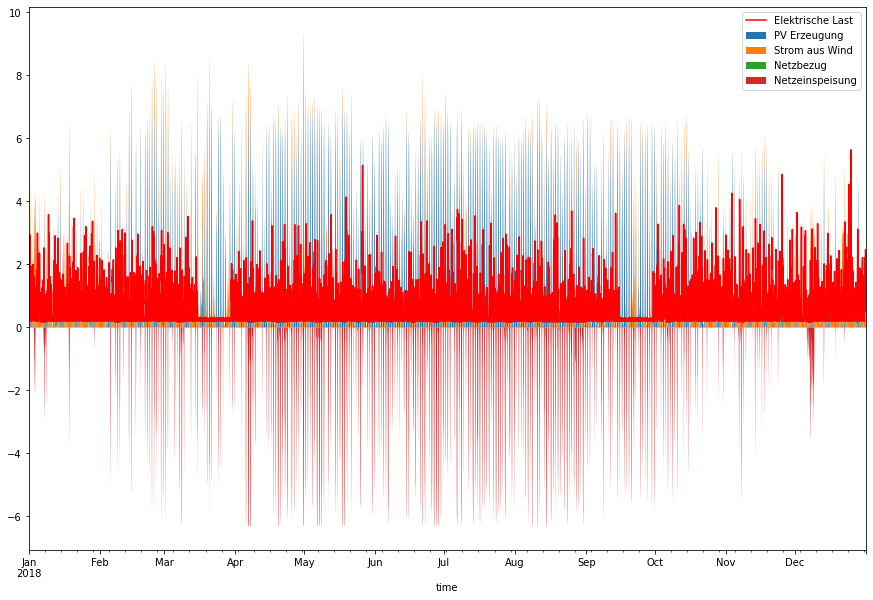

In [48]:
load_figure = network_mod_all.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_with_all = pd.concat([network_mod_all.generators_t.p['pv'], network_mod_all.generators_t.p['wind'], network_mod_all.generators_t.p['grid_import'], -network_mod_all.generators_t.p['grid_export']], axis = 1)
df_figure_with_all.columns = ['PV Erzeugung', 'Strom aus Wind', 'Netzbezug', 'Netzeinspeisung']
df_figure_with_all.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax = ax)

In [49]:
energy_figure_all = pd.DataFrame([results_energy_base, results_energy_with_all], index = ['Basis', 'Mit Modifikationen'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh'}>

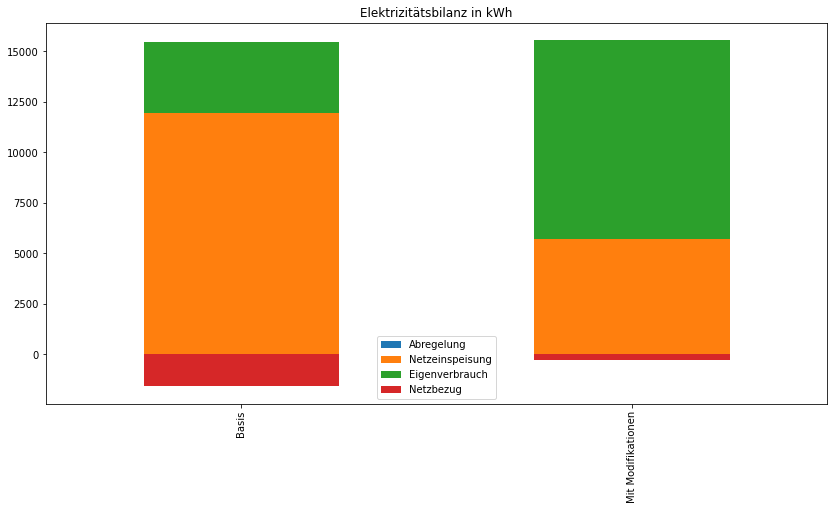

In [50]:
energy_figure_all.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')

# Zusammenfassung

In [51]:
energy_figure_vergleich = pd.DataFrame([results_energy_base, results_energy_with_hp, results_energy_with_hwt, results_energy_with_bat, results_energy_with_all], index = ['Basis', 'Mit Wärmepumpe', 'Mit WW-Speicher', 'Mit Batterie', 'Mit allen Modifikationen'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh'}>

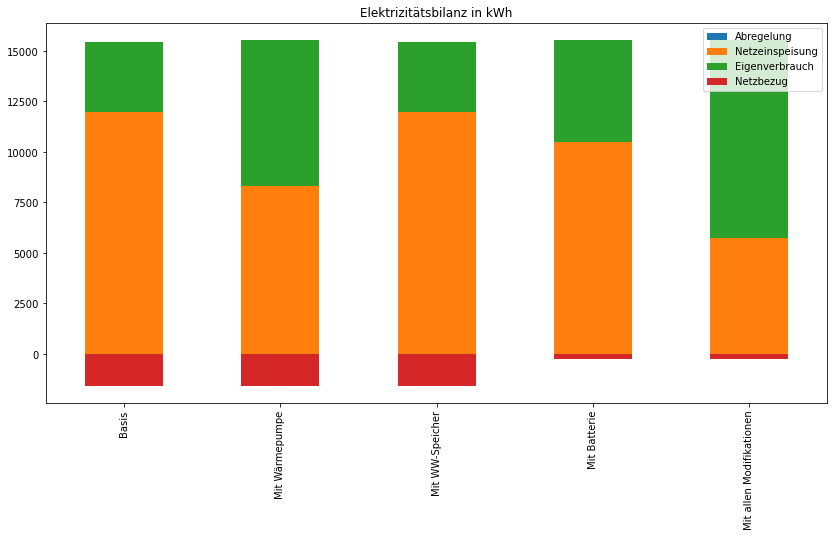

In [52]:
energy_figure_vergleich.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')

In [63]:
# Ausführung der Auswertungsfunktion


print("Vergleich der Modelle"
+"\nModelltypen:                  |Basis            |Wärmepumpe      |Wärmespeicher   |Batteriespeicher|Komplett        |"
+"\n----------------------------------------------------------------------------------------------------------------"
+"\nEigenverbrauchsanteil in %:   | "+str(round(results_base["Eigenverbrauchsanteil"]*100,2))+"           |"
+str(round(results_with_hp["Eigenverbrauchsanteil"]*100,2))+"           |"
+str(round(results_with_hwt["Eigenverbrauchsanteil"]*100,2))+"           |"
+str(round(results_with_bat["Eigenverbrauchsanteil"]*100,2))+"           |"
+str(round(results_with_all["Eigenverbrauchsanteil"]*100,2))+"           |"
+"\nStromerlöse in €:             | "+str(round(results_base["Stromerlöse"]/100,2))+"         |"
+str(round(results_with_hp["Stromerlöse"]/100,2))+"         |"
+str(round(results_with_hwt["Stromerlöse"]/100,2))+"         |"
+str(round(results_with_bat["Stromerlöse"]/100,2))+"         |"
+str(round(results_with_all["Stromerlöse"]/100,2))+"          |"
+"\nEnergiekosten in €:           | "+str(round(results_base["Energiekosten"]/100,2))+"         |"
+str(round(results_with_hp["Energiekosten"]/100,2))+"         |"
+str(round(results_with_hwt["Energiekosten"]/100,2))+"         |"
+str(round(results_with_bat["Energiekosten"]/100,2))+"         |"
+str(round(results_with_all["Energiekosten"]/100,2))+"         |"
+"\n  Stromkosten in €:           | "+str(round(results_base["Stromkosten"]/100,2))+"          |"
+str(round(results_with_hp["Stromkosten"]/100,2))+"          |"
+str(round(results_with_hwt["Stromkosten"]/100,2))+"          |"
+str(round(results_with_bat["Stromkosten"]/100,2))+"           |"
+str(round(results_with_all["Stromkosten"]/100,2))+"           |"
+"\n  Gaskosten in €:             | "+str(round(results_base["Gaskosten"]/100,2))+"         |"
+str(round(results_with_hp["Gaskosten"]/100,2))+"         |"
+str(round(results_with_hwt["Gaskosten"]/100,2))+"         |"
+str(round(results_with_bat["Gaskosten"]/100,2))+"         |"
+str(round(results_with_all["Gaskosten"]/100,2))+"          |"
+"\nGesamtkosten in €:            | "+str(round(results_base["Energiekosten"]/100,2))+"         |"
+str(round((results_with_hp["Energiekosten"]+zusätzliche_Kosten_wp)/100,2))+"         |"
+str(round((results_with_hwt["Energiekosten"] + zusätzliche_Kosten_hwt)/100,2))+"         |"
+str(round((results_with_bat["Energiekosten"]+zusätzliche_Kosten_bat)/100,2))+"         |"
+str(round((results_with_all["Energiekosten"]+zusätzliche_Kosten_all)/100,2))+"         |"
+"\nCashflow 2018 in €:           | "+str(round((cashflow_base)/100,2))+"          |"
+str(round((cashflow_hp)/100,2))+"        |"
+str(round((cashflow_hwt)/100,2))+"          |"
+str(round((cashflow_bat)/100,2))+"        |"
+str(round((cashflow_all)/100,2))+"        |"
+"\n"
                                    
                                    )

Vergleich der Modelle
Modelltypen:                  |Basis            |Wärmepumpe      |Wärmespeicher   |Batteriespeicher|Komplett        |
----------------------------------------------------------------------------------------------------------------
Eigenverbrauchsanteil in %:   | 68.98           |82.13           |68.98           |95.21           |97.48           |
Stromerlöse in €:             | 1469.02         |1019.73         |1469.02         |1291.38         |706.05          |
Energiekosten in €:           | 2363.42         |1625.46         |2363.42         |1967.98         |1044.31         |
  Stromkosten in €:           | 471.59          |471.59          |471.59          |76.15           |76.15           |
  Gaskosten in €:             | 1891.83         |1153.87         |1891.83         |1891.83         |968.16          |
Gesamtkosten in €:            | 2363.42         |3380.46         |2463.42         |2867.98         |3799.31         |
Cashflow 2018 in €:           | -894.4 

## Zum Vergleich: Kobi_System ohne Wärmespeicher

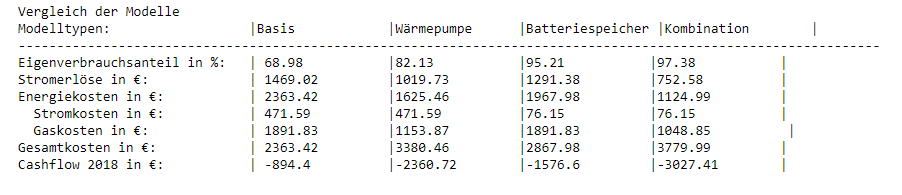

In [54]:
Image(filename='kombi_ohne_hwt.PNG')

## Zum Vergleich: Kombi_System ohne Batteriespeicher


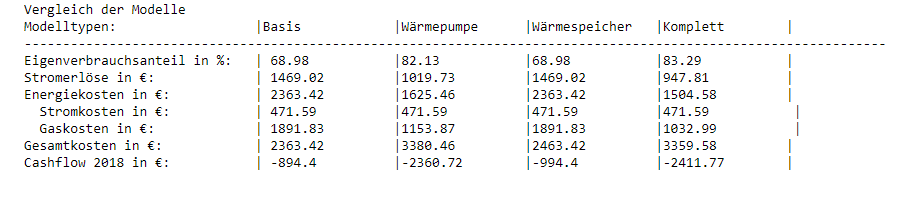

In [59]:
Image(filename='kombi_ohne_bat.PNG')

In [55]:
results_with_bat, results_energy_with_bat = cost_share_evaluation(network_mod_bat)
results_with_hwt, results_energy_with_hwt = cost_share_evaluation(network_mod_hwt)
results_with_hp, results_energy_with_hp = cost_share_evaluation(network_mod_hp)
results_base, results_energy_base = cost_share_evaluation(network)
results_with_all, results_energy_with_all = cost_share_evaluation(network_mod_all) # Funktion übergeben
#Zusätzliche Kosten
zusätzliche_Kosten_bat = battery_storage["annuity_cost"]*100
zusätzliche_Kosten_hwt = hot_water_storage["annuity_cost"]*100 #jahrliche Kosten in Cent
zusätzliche_Kosten_wp = heat_pump["Investition"]*heat_pump["Annuitätsfaktor"]*100
zusätzliche_Kosten_all = zusätzliche_Kosten_wp +zusätzliche_Kosten_hwt +zusätzliche_Kosten_bat
#Berechnung Cashflow
cashflow_bat = results_with_bat["Stromerlöse"]-results_with_bat["Energiekosten"]- zusätzliche_Kosten_bat
cashflow_hwt = results_with_hwt["Stromerlöse"]-results_with_hwt["Energiekosten"]- zusätzliche_Kosten_hwt
cashflow_hp = results_with_hp["Stromerlöse"]-results_with_hp["Energiekosten"]- zusätzliche_Kosten_wp
cashflow_base = results_base["Stromerlöse"]-results_base["Energiekosten"]
cashflow_all = cashflow_bat = results_with_all["Stromerlöse"]-results_with_all["Energiekosten"]- zusätzliche_Kosten_all

In [56]:
heat_pump["Investition"]*heat_pump["Annuitätsfaktor"]

1755.0

Nicht im Programm mit simulieren (Hilfestellungen, Testcode, etc.)

In [57]:
# Ausführung der Auswertungsfunktion
results_with_all, results_energy_with_all = cost_share_evaluation(network_mod_all) # Funktion übergeben
#Zusätzliche Kosten
zusätzliche_Kosten_all = zusätzliche_Kosten_wp +zusätzliche_Kosten_hwt +zusätzliche_Kosten_bat
#Berechnung von au. Cashflow, Gesamtkosten, Selbstverbrauch
cashflow_all = cashflow_bat = results_with_all["Stromerlöse"]-results_with_all["Energiekosten"]- zusätzliche_Kosten_all


print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
+ str(round(results_with_all["Eigenverbrauchsanteil"]*100,2))
+"%.\n Dabei entstehen Stromkosten von "
+str(round(results_with_all["Stromkosten"]/100,2))
+"€, Gaskosten von "
+str(round(results_with_all["Gaskosten"]/100,2))
+"€ und EEG-Erlöse von "
+str(round(results_with_all["Stromerlöse"]/100,2))
+", wobei " +str(round(results_with_all["Nicht nutzbare Energie"]/100,1))
+ "kWh PV-Strom abgeregelt werden müssen.\n"
+" Die Gesamtkosten betragen "+ str(round((results_with_all["Energiekosten"]+zusätzliche_Kosten_all)/100,2)) 
+"€.\n"
+"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
+str(round((results_with_all["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
+" Prozentpunkte und eine Verringerung der Kosten um "
+str(round((cashflow_all - cashflow_base)/100,2))
+"€."
+" Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_all)/100,2))
+"€.\n")


Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 97.48%.
 Dabei entstehen Stromkosten von 76.15€, Gaskosten von 968.16€ und EEG-Erlöse von 706.05, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 3799.31€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 28.5 Prozentpunkte und eine Verringerung der Kosten um -2198.86€. Der Cashflow für das Jahr 2018 beträgt somit -3093.26€.



In [58]:

print("Vergleich der Modelle"
+"\n|Basis             |Wärmepumpe        |Wärmespeicher      |Batteriespeicher  |Komplett          |"
+Dabei entstehen Stromkosten von 
    Eigenverbrauchsanteil  |   Basisam Stromverbrauch in der erweiterten Konfiguration beträgt "
+ str(round(results_with_bat["Eigenverbrauchsanteil"]*100,2))
+"%.\n Dabei entstehen Stromkosten von "
+str(round(results_with_bat["Stromkosten"]/100,2))
+"€, Gaskosten von "
+str(round(results_with_bat["Gaskosten"]/100,2))
+"€ und EEG-Erlöse von "
+str(round(results_with_bat["Stromerlöse"]/100,2))
+", wobei " +str(round(results_with_bat["Nicht nutzbare Energie"]/100,1))
+ "kWh PV-Strom abgeregelt werden müssen.\n"
+" Die Gesamtkosten betragen "+ str(round((results_with_bat["Energiekosten"]+zusätzliche_Kosten_bat)/100,2)) 
+"€.\n"
+"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
+str(round((results_with_bat["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
+" Prozentpunkte und eine Verringerung der Kosten um "
+str(round((cashflow_bat - cashflow_base)/100,2))
+"€."
+" Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_bat)/100,2))
+"€.\n")





print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
+ str(round(results_with_hwt["Eigenverbrauchsanteil"]*100,2))
+"%.\n Dabei entstehen Stromkosten von "
+str(round(results_with_hwt["Stromkosten"]/100,2))
+"€, Gaskosten von "
+str(round(results_with_hwt["Gaskosten"]/100,2))
+"€ und EEG-Erlöse von "
+str(round(results_with_hwt["Stromerlöse"]/100,2))
+", wobei " +str(round(results_with_hwt["Nicht nutzbare Energie"]/100,1))
+ "kWh PV-Strom abgeregelt werden müssen.\n"
+" Die Gesamtenergiekosten betragen "+ str(round((results_with_hwt["Energiekosten"]+zusätzliche_Kosten_hwt)/100,2))
+"€.\n"
+"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
+str(round((results_with_hwt["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
+" Prozentpunkte und eine Verringerung der Kosten um "
+str(round((cashflow_hwt-cashflow_base)/100,2))
+"€. "
+ "Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_hwt)/100,2))
+ "€.\n")



print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
+str(round(results_with_hp["Eigenverbrauchsanteil"]*100,2))
+"\n Dabei entstehen Stromkosten von "
+str(round(results_with_hp["Stromkosten"]/100,2))
+"€, Gaskosten von "
+str(round(results_with_hp["Gaskosten"]/100,2))
+"€ und EEG-Erlöse von "
+str(round(results_with_hp["Stromerlöse"]/100,2))
+", wobei " 
+str(round(results_with_hp["Nicht nutzbare Energie"]/100,4))
+"kWh PV-Strom abgeregelt werden müssen.\n"
+" Die Gesamtenergiekosten betragen "
+str(round((results_with_hp["Energiekosten"] + zusätzliche_Kosten_wp)/100,2))
+"€.\n"
+"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
+str(round((results_with_hp["Eigenverbrauchsanteil"] - results_base["Eigenverbrauchsanteil"])*100,2))
+" Prozentpunkte und eine Verringerung der Kosten um "
+str(round((cashflow_hp-cashflow_base)/100,2))
+"€. "
+ "Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_hp)/100,2))
+ "€.\n")


print("Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt "
      + str(round(results_base["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_base["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_base["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_base["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_base["Nicht nutzbare Energie"]/100,4))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtenergiekosten betragen "+ str(round(results_base["Energiekosten"]/100,2)) 
      +"€.\n"
      + "Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_base)/100,2))
      + "€.\n")



print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
+ str(round(results_with_all["Eigenverbrauchsanteil"]*100,2))
+"%.\n Dabei entstehen Stromkosten von "
+str(round(results_with_all["Stromkosten"]/100,2))
+"€, Gaskosten von "
+str(round(results_with_all["Gaskosten"]/100,2))
+"€ und EEG-Erlöse von "
+str(round(results_with_all["Stromerlöse"]/100,2))
+", wobei " +str(round(results_with_all["Nicht nutzbare Energie"]/100,1))
+ "kWh PV-Strom abgeregelt werden müssen.\n"
+" Die Gesamtkosten betragen "+ str(round((results_with_all["Energiekosten"]+zusätzliche_Kosten_all)/100,2)) 
+"€.\n"
+"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
+str(round((results_with_all["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
+" Prozentpunkte und eine Verringerung der Kosten um "
+str(round((cashflow_all - cashflow_base)/100,2))
+"€."
+" Der Cashflow für das Jahr 2018 beträgt somit " + str(round((cashflow_all)/100,2))
+"€.\n")



SyntaxError: invalid syntax (<ipython-input-58-0518ea347df9>, line 3)

In [ ]:
'''
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):

    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum()
    grid_export = (network.generators_t.p['grid_export'] * network.snapshot_weightings).sum()
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum()- grid_export
    self_consumed_wind = (network.generators_t.p['wind'] * network.snapshot_weightings).sum()
    self_consumption_ratio = (self_consumed_pv + self_consumed_wind) /(grid_import + self_consumed_pv + self_consumed_wind)
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricty_revenues = grid_export * network.generators.marginal_cost['grid_export']
    gas_costs = (network.generators_t.p['boiler']*network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
    annuity_cost = ((hot_water_storage['annuity_cost'] + heat_pump['Investition']/AnzJ + battery_storage["annuity_cost"])*100)
    
    curtailment = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()

    results = {"Eigenverbrauchsanteil": self_consumption_ratio,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricty_revenues,
              "Gesamtkosten": electricity_cost + gas_costs + electricty_revenues + annuity_cost,
              "Nicht nutzbare Energie": curtailment}
    results_energy = {'Abregelung': curtailment,
                      'Netzeinspeisung': grid_export,
                      'Eigenverbrauch': self_consumed_pv + self_consumed_wind,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy
'''


In [ ]:
'''
# Ausführung der Auswertungsfunktion
results, results_energy = cost_share_evaluation(network)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results["Stromerlöse"]/100,2))
      +", wobei " +str(round(results["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results["Gesamtkosten"]/100,2)) 
      +"€.\n")
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_with_modification["Gesamtkosten"])/100,2))
      +"€."
     )
'''
     



# Visualisierung der Ergebnisse

In [ ]:
'''total_load = pd.concat([network.loads_t.p_set['electricity_load'], network.links_t.p0['heat_pump']], axis = 1)
total_load.columns = ['Elektrische Last', 'Wärmepumpe']
ax = total_load.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_with_modification = pd.concat([network.generators_t.p['pv'], network.generators_t.p['wind'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export']], axis = 1)
df_figure_with_modification.columns = ['PV Erzeugung', 'Strom aus Wind', 'Netzbezug', 'Netzeinspeisung']
df_figure_with_modification.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax = ax)
'''

In [ ]:
'''energy_figure = pd.DataFrame([results_energy], index = ['Mit Modifikation'])'''

In [ ]:
'''energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')'''